# Detect freshness of fruits using PyTorch
<br>
<img src='https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png'/>
<br>
Through this tutorial I will be giving a step by step guide to tackle a simple deep learning problem. In this notebook I will train a model to detect the freshness of the fruit and then use this model to create a simple app deployed on the web so that anyone and play with it. For the latter part, I have created a [github project](https://github.com/anshuls235/freshness-detector) and the app can be accessed through this [link](https://freshness-detector.herokuapp.com/).
<br><br>

### Now lets first train our model!!

# Importing the Libraries

In [1]:
#For accessing files
import os
import glob

#For Images
import cv2
import matplotlib.pyplot as plt
import numpy as np

#For checking progress
#from tqdm import tqdm_notebook

import datetime

#PyTorch Packages
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Studying the data
Let's take a look at the data on which we will be training our data and the one on which we will be doing our predictions.

In [2]:
def get_image(path,transform=False):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if transform:
        img = transform(img)
    return img

def show_data(rows,cols,is_train=True,transform=False):
    if is_train:
        path = os.path.abspath(os.getcwd()+'\\archive\\dataset\\dataset\\train\\')
    else:
        path = os.path.abspath(os.getcwd()+'\\archive\\dataset\\dataset\\test\\')    
    path = os.path.join(path,'*','*.png')
    img_paths = glob.glob(path)
    np.random.seed(0)
    img_paths = np.random.choice(img_paths,rows*cols)
    fig = plt.figure(figsize=(8,8),dpi=150)
    i = 1
    for r in range(rows):
        for c in range(cols):
            image_path = img_paths[i-1]
            if 'fresh' in image_path.split('\\')[-2]:
                title = 'Fresh'
            else:
                title = 'Rotten'
            ax = fig.add_subplot(rows,cols,i)
            img = get_image(image_path,transform)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title,fontsize=5)
            ax.imshow(img)
            i+=1
    return fig

## Test Data
We already have the labels so that we can test our model's accuracy. Just showing the labels to show the images in test data.

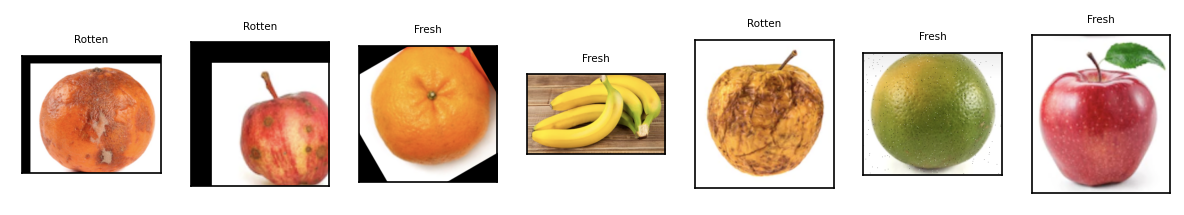

In [3]:
fig = show_data(1,7,is_train=False)
fig.tight_layout()

# PyTorch Datasets and Dataloaders
The dataset which is provided to us is just images in separate folders: `freshapples`,`freshbanana`,`freshoranges`,`rottenapples`,`rottenbanana` & `rottenoranges`. These folders are common subfolders in train and test folders.

A lot of effort in solving any machine learning problem goes in to preparing the data. PyTorch provides many tools to make data loading easy and hopefully, to make your code more readable.

## Custom Dataset
`torch.utils.data.Dataset` is an abstract class representing a dataset. The custom dataset should inherit Dataset and override the following methods:

- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that dataset[i] can be used to get ith sample

So, I'll be creating a custom dataset `FruitsDataset` which inherits Dataset class and overrides the above methods.

In [83]:
class FruitsDataset(Dataset):
    def __init__(self,path,classifier_type='Rotten',subset='train',transforms=None):
        self.subset = subset
        if self.subset == 'train':
            self.PATH = os.path.join(path,'train','*','*.png')
        elif self.subset == 'test' and classifier_type=='Rotten':
            self.PATH = os.path.join(path,'test','rottenapples','*.png')
        else:
            self.PATH = os.path.join(path,'test','freshapples','*.png')
        #print(self.PATH)
        self.data = glob.glob(self.PATH)
        self.height = 32
        self.width = 32
        self.labels = [] 
        if classifier_type == 'Rotten':
            classes = ['fresh','rotten']
            for fruit in self.data:
                if classes[0] in fruit.split('\\')[-2]:
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        else:
            classes = ['apple','banana','orange']
            for fruit in self.data:
                if classes[0] in fruit:
                    self.labels.append(0)
                elif classes[1] in fruit:
                    self.labels.append(1)
                else:
                    self.labels.append(2)
        self.transforms = transforms
      
    def __getitem__(self,index):
        img_path = self.data[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(self.width,self.height))
        label = self.labels[index]
        if self.transforms is not None:
            img_as_tensor = self.transforms(img)
            if self.transforms is not None:
                return(img_as_tensor,label)
            return(img,label)
  
    def __len__(self):
        return(len(self.data))

## Transforms
One issue we can face is the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some prepocessing code. Let’s create two transforms:

- `ToTensor`: to convert the numpy images to torch images (we need to swap axes).
- `Normalize`: so that the images have zero mean and one variance.

**Please Note: ** For rescaling the images to 32x32 size(This is the size I have chosen) I have used cv2. Instead, we can simply use `Rescale()` transform 

In [72]:
transformations = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7321, 0.6322, 0.5291),
                                                           (0.3302, 0.3432, 0.3701))
                                      ])
dataset = FruitsDataset(os.getcwd()+'\\archive\\dataset\\dataset\\',transforms = transformations)

Let's take a look at a random image from the dataset we have created. I have used permute function because images are usually represented as `Height x Width x #Channels` where #Channels is 3 for RGB images and 1 for grayscale images. While, pytorch tensors are represented as `#Channels x Height x Width`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


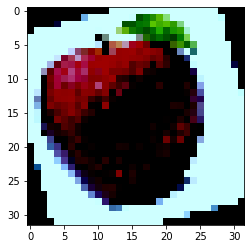

In [73]:
img_t, _ = dataset[100]
img = img_t.permute(1,2,0)
plt.imshow(img);

You will be seeing a very distored image of a fruit. Its because of the transformations applied to have a common size for all the images. I have chosen such a small size for reducing the training time.

## DataLoaders
We can iterate over the created dataset with a simple `for` loop. However, we are losing a lot of features by using a simple `for` loop to iterate over the data. In particular, we are missing out on:

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. I will create separate loaders for training and validation with sampling.

# Creating the Model
Let's redifine the `nn.Module` class to create our custom NN.

In [74]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Lets check the number of parameters we have to train.

In [75]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Confirm if we are training on GPU.

In [76]:
device = (torch.device('cpu') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


# Loading our model

In [77]:
checkpoint = torch.load('FreshnessDetector.pt')
model.load_state_dict(checkpoint)
#model.state_dict() = torch.load('FreshnessDetector.pt')

<All keys matched successfully>

Let's check one sample.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual: 0
Prediction: tensor([[ 1.2019, -0.7566]], grad_fn=<AddmmBackward>)
0


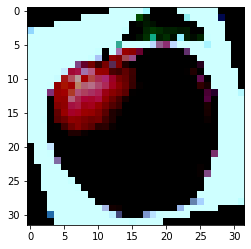

In [78]:
img,label = dataset[0]
plt.imshow(img.permute(1,2,0))
out = model(img.unsqueeze(0).to(device))
print('Actual: {}'.format(label))
print('Prediction: {}'.format(out))
print(label)

# Evaluating our model
Apply the same transformation on the test dataset. 

In [79]:
transformations_test = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7369, 0.6360, 0.5318),
                                                           (0.3281, 0.3417, 0.3704))
                                      ])
test = FruitsDataset(os.getcwd()+'\\archive\\dataset\\dataset\\',subset='test',transforms=transformations_test)

NameError: name 'classifer_type' is not defined

The values sent to normalize are calculated using the code below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: tensor([[0.6681, 0.3319]], grad_fn=<SoftmaxBackward>)


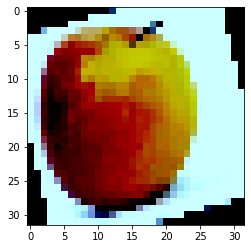

In [80]:
img,_ = test[29]
plt.imshow(img.permute(1,2,0))
s = nn.Softmax(dim=1)
out = s(model(img.unsqueeze(0).to(device)))
print('Prediction: {}'.format(out))

In [90]:
import random
transformations = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7321, 0.6322, 0.5291),
                                                           (0.3302, 0.3432, 0.3701))
                                      ])
badtest = FruitsDataset(os.getcwd()+'\\archive\\dataset\\dataset\\',subset='test',transforms=transformations_test)
goodtest= FruitsDataset(os.getcwd()+'\\archive\\dataset\\dataset\\',subset='test',classifier_type = 'rotten',transforms=transformations_test)
def plotandpredict(name):
    if name=='green':
        #bad apple
        img,label = badtest[random.randint(1,100)];
        plt.imshow(img.permute(1,2,0))
        s = nn.Softmax(dim=1)
        out = s(model(img.unsqueeze(0).to(device)))
        if out[0][0]>out[0][1]:
            print('Prediction: fresh')
        else:
            print('Prediction: rotten')
    else:
        #good apple
        img,label = goodtest[random.randint(1,100)];
        plt.imshow(img.permute(1,2,0))
        s = nn.Softmax(dim=1)
        out = s(model(img.unsqueeze(0).to(device)))
        if out[0][0]>out[0][1]:
            print('Prediction: fresh')
        else:
            print('Prediction: rotten')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: fresh


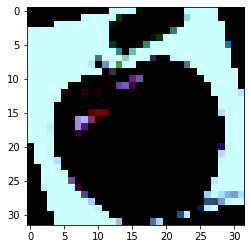

In [92]:
plotandpredict(name='red')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: rotten


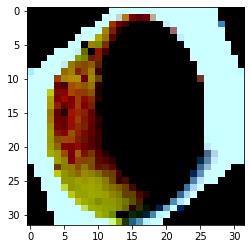

In [93]:
plotandpredict(name='green')

In [ ]:
def randplotandpredict():
    